# Checking the functions for the block iterative solution

In [2]:
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import scipy.stats
import scipy
from astropy import units,coordinates as coord
import pandas as pd

jax.config.update('jax_enable_x64', True)

In [5]:
from generateobs import generate_mock_obs,generate_mock_obs_simple
from iterativesolver import update_source_inner,update_source,update_attitude_inner,update_attitude,bloc_iteration,_Jacobian_autodiff
from propagation import _icrs2comrs,_comrs2fovrs,_comrs2fprs,_fovrs2fprs

ModuleNotFoundError: No module named 'generateobs'

In [4]:
_astronomicalunit_to_meters = units.astronomical_unit.to(units.meter)
_radiants_to_mas = units.radian.to(units.mas)

# Test 1

## Two-step model with simple observed field

### Generate true values

In [4]:
pkey = jax.random.PRNGKey(42)
alpha00 = 266.4
delta00 = -28.9
pt_ra0 = 266.40498829
pt_dec0 = -28.93617776
pt_rot0 = 58.61
F0 = 1

source_id = jnp.arange(500)
alpha0 = np.deg2rad(alpha00)+np.random.uniform(-1.0, 1.0, size=source_id.shape)
delta0 = np.deg2rad(delta00)+np.random.uniform(-1.0, 1.0, size=source_id.shape)

exposure_id = jnp.arange(1000)
ep = jnp.linspace(0,3, exposure_id.size)
pt_ra = np.deg2rad(pt_ra0) + np.random.uniform(-0.5, 0.5, size=exposure_id.shape)
pt_dec = np.deg2rad(pt_dec0) + np.random.uniform(-0.5, 0.5, size=exposure_id.shape)
pt_rot = np.deg2rad(pt_rot0) + np.random.uniform(-0.1,0.1, size=exposure_id.shape)
F = F0*np.random.uniform(0.9,1.1, size=exposure_id.shape)

src = np.stack([source_id, alpha0, delta0]).T
att = np.stack([exposure_id, ep, pt_ra,pt_dec,pt_rot,F]).T

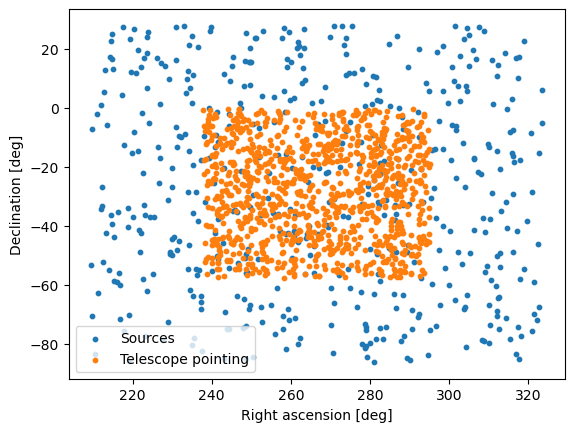

In [5]:
plt.scatter(np.rad2deg(alpha0),np.rad2deg(delta0),s=10,color="tab:blue",label="Sources");
plt.scatter(np.rad2deg(pt_ra),np.rad2deg(pt_dec),s=10,color="tab:orange",label="Telescope pointing");
plt.xlabel("Right ascension [deg]")
plt.ylabel("Declination [deg]");
plt.legend();

### Generate first guess

In [6]:
src_guess_error = 10/_radiants_to_mas #based on Gaia positional precision
att_guess_error = 1000/_radiants_to_mas

src_guess_errors = np.random.uniform(-src_guess_error, src_guess_error, size=src[:, 1:].shape)
shat = src + 0
shat[:,1:] = src[:,1:] + src_guess_errors

att_guess_errors = np.random.uniform(-att_guess_error, att_guess_error, size=att[:, 1:].shape)
ahat = att + 0
ahat[:,1:] = att[:,1:] + att_guess_errors

### Generate model

In [7]:
model = jax.jit(lambda s,a,c,t: jnp.asarray(_fovrs2fprs(*_comrs2fovrs(s[0],s[1],a[0],a[1],a[2]),a[3])))

### Generate mock observations

In [8]:
sig_obs = 100/_radiants_to_mas
obs = generate_mock_obs_simple(src,att,None,model,sig_obs)

### Block iteration

In [9]:
%%time
src_opt,att_opt,cal_opt = bloc_iteration(shat,ahat,None,obs,model,2,5,2)

CPU times: user 1min 26s, sys: 19.8 s, total: 1min 46s
Wall time: 1min 25s


### Plot results

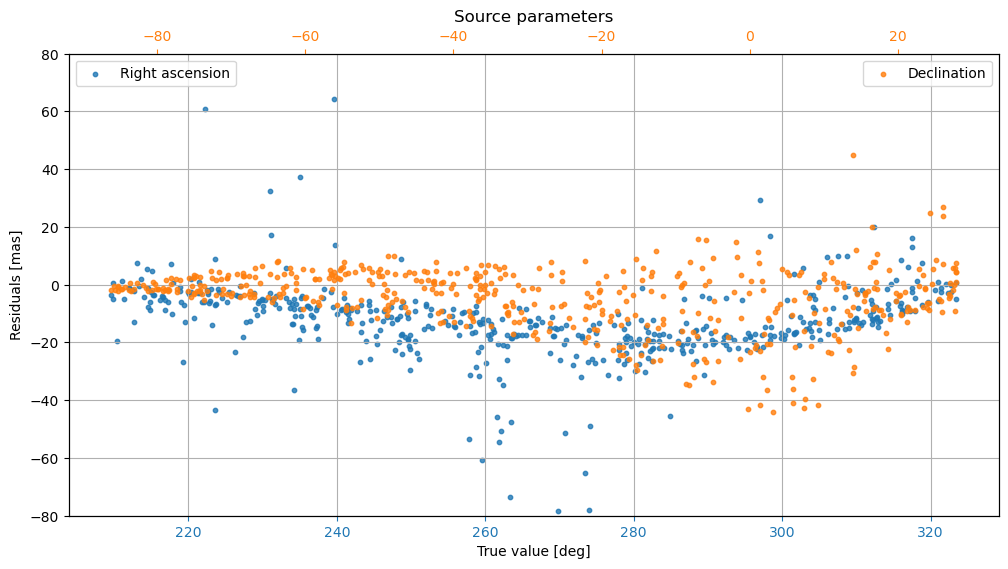

In [10]:
fig,ax = plt.subplots(figsize=(12,6))
ax.scatter(np.rad2deg(src[:,1]),(src_opt[:,1] - src[:,1])*_radiants_to_mas,label="Right ascension",s=10,alpha=0.8,color="tab:blue");

ax2 = ax.twiny()
ax2.scatter(np.rad2deg(src[:,2]),(src_opt[:,2] - src[:,2])*_radiants_to_mas,label="Declination",s=10,alpha=0.8,color="tab:orange");

ax.legend(loc="upper left")
ax2.legend(loc="upper right")
ax.tick_params(axis='x', colors='tab:blue')
ax2.tick_params(axis='x', colors='tab:orange')
ax.set_ylabel("Residuals [mas]")
ax.set_xlabel("True value [deg]")
ax.set_title("Source parameters")
ax.set_ylim(-80,80);
ax.grid();

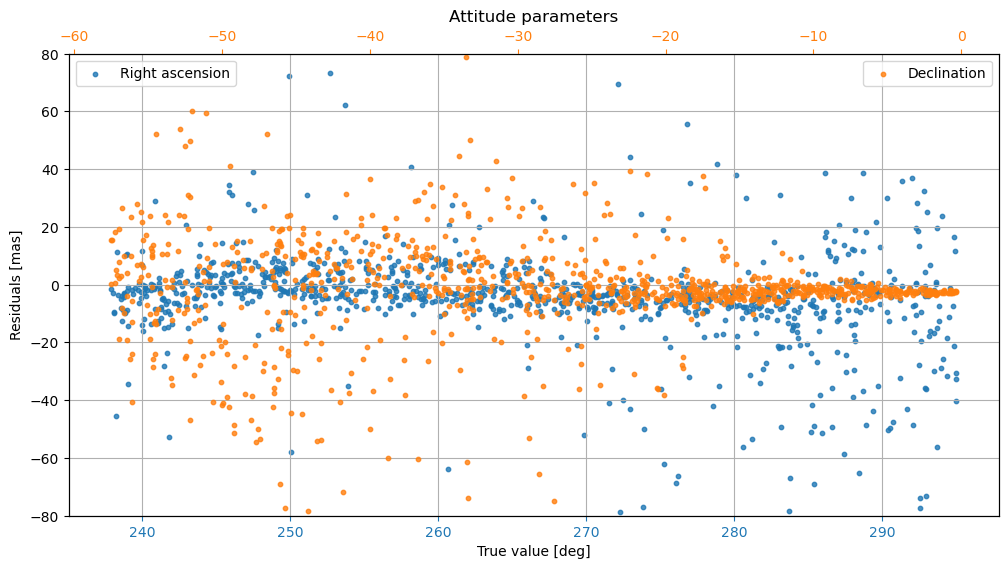

In [11]:
fig,ax = plt.subplots(figsize=(12,6))

ax.scatter(np.rad2deg(att[:,2]),(att_opt[:,2] - att[:,2])*_radiants_to_mas,label="Right ascension",s=10,alpha=0.8,color="tab:blue");

ax2 = ax.twiny()
ax2.scatter(np.rad2deg(att[:,3]),(att_opt[:,3] - att[:,3])*_radiants_to_mas,label="Declination",s=10,alpha=0.8,color="tab:orange");

ax.legend(loc="upper left")
ax2.legend(loc="upper right")
ax.tick_params(axis='x', colors='tab:blue')
ax2.tick_params(axis='x', colors='tab:orange')
ax.set_ylabel("Residuals [mas]")
ax.set_xlabel("True value [deg]")
ax.set_title("Attitude parameters")
ax.set_ylim(-80,80);
ax.grid();

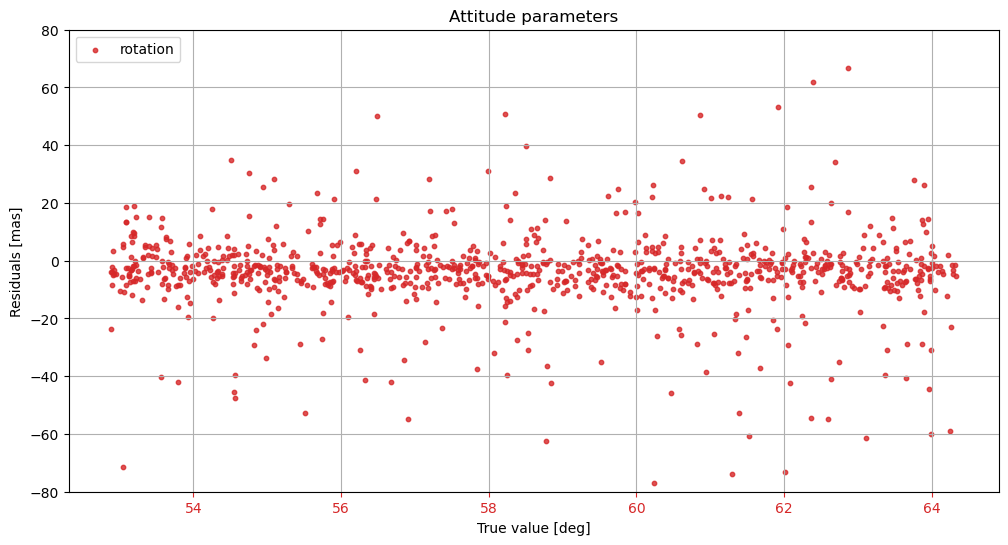

In [12]:
fig,ax = plt.subplots(figsize=(12,6))

ax.scatter(np.rad2deg(att[:,4]),(att_opt[:,4] - att[:,4])*_radiants_to_mas,label="rotation",s=10,alpha=0.8,color="tab:red");

ax.legend(loc="upper left")
ax.tick_params(axis='x', colors='tab:red')
ax.set_ylabel("Residuals [mas]")
ax.set_xlabel("True value [deg]")
ax.set_title("Attitude parameters")
ax.set_ylim(-80,80);
ax.grid();

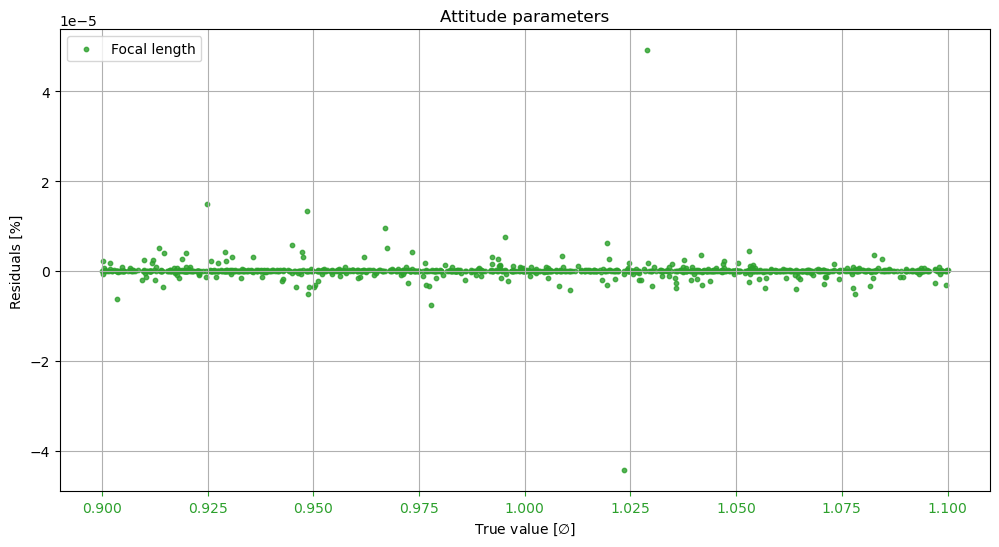

In [13]:
fig,ax = plt.subplots(figsize=(12,6))

ax.scatter(att[:,5],(att_opt[:,5] - att[:,5]),label="Focal length",s=10,alpha=0.8,color="tab:green");

ax.legend(loc="upper left")
ax.tick_params(axis='x', colors='tab:green')
ax.set_ylabel("Residuals [%]")
ax.set_xlabel(r"True value [$\emptyset$]")
ax.set_title("Attitude parameters")
#ax.set_ylim(-0.0005,0.0005);
ax.grid();

## One-step model with simple observed field

### Generate true values

In [4]:
pkey = jax.random.PRNGKey(42)
alpha00 = 266.4
delta00 = -28.9
pt_ra0 = 266.40498829
pt_dec0 = -28.93617776
pt_rot0 = 58.61
F0 = 1

source_id = jnp.arange(500)
alpha0 = np.deg2rad(alpha00)+np.random.uniform(-1.0, 1.0, size=source_id.shape)
delta0 = np.deg2rad(delta00)+np.random.uniform(-1.0, 1.0, size=source_id.shape)

exposure_id = jnp.arange(1000)
ep = jnp.linspace(0,3, exposure_id.size)
pt_ra = np.deg2rad(pt_ra0) + np.random.uniform(-0.5, 0.5, size=exposure_id.shape)
pt_dec = np.deg2rad(pt_dec0) + np.random.uniform(-0.5, 0.5, size=exposure_id.shape)
pt_rot = np.deg2rad(pt_rot0) + np.random.uniform(-0.1,0.1, size=exposure_id.shape)
F = F0*np.random.uniform(0.9,1.1, size=exposure_id.shape)

src = np.stack([source_id, alpha0, delta0]).T
att = np.stack([exposure_id, ep, pt_ra,pt_dec,pt_rot,F]).T

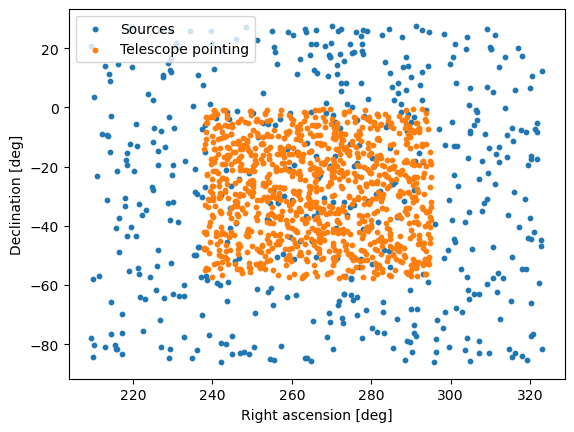

In [42]:
plt.scatter(np.rad2deg(alpha0),np.rad2deg(delta0),s=10,color="tab:blue",label="Sources");
plt.scatter(np.rad2deg(pt_ra),np.rad2deg(pt_dec),s=10,color="tab:orange",label="Telescope pointing");
plt.xlabel("Right ascension [deg]")
plt.ylabel("Declination [deg]");
plt.legend();

### Generate first guess

In [5]:
src_guess_error = 10/_radiants_to_mas #based on Gaia positional precision
att_guess_error = 1000/_radiants_to_mas

src_guess_errors = np.random.uniform(-src_guess_error, src_guess_error, size=src[:, 1:].shape)
shat = src + 0
shat[:,1:] = src[:,1:] + src_guess_errors

att_guess_errors = np.random.uniform(-att_guess_error, att_guess_error, size=att[:, 1:].shape)
ahat = att + 0
ahat[:,1:] = att[:,1:] + att_guess_errors

### Generate model

In [14]:
model = jax.jit(lambda s,a,c,t: jnp.asarray(_comrs2fprs(s[0],s[1],a[0],a[1],a[2],a[3])))

### Generate mock observations

In [69]:
sig_obs = 100/_radiants_to_mas
obs = generate_mock_obs_simple(src,att,None,model,sig_obs)

### Block iteration

In [15]:
%%time
src_opt,att_opt,cal_opt = bloc_iteration(shat,ahat,None,obs,model,2,5,2)

CPU times: user 1min 18s, sys: 19.5 s, total: 1min 38s
Wall time: 1min 18s


### Plot results

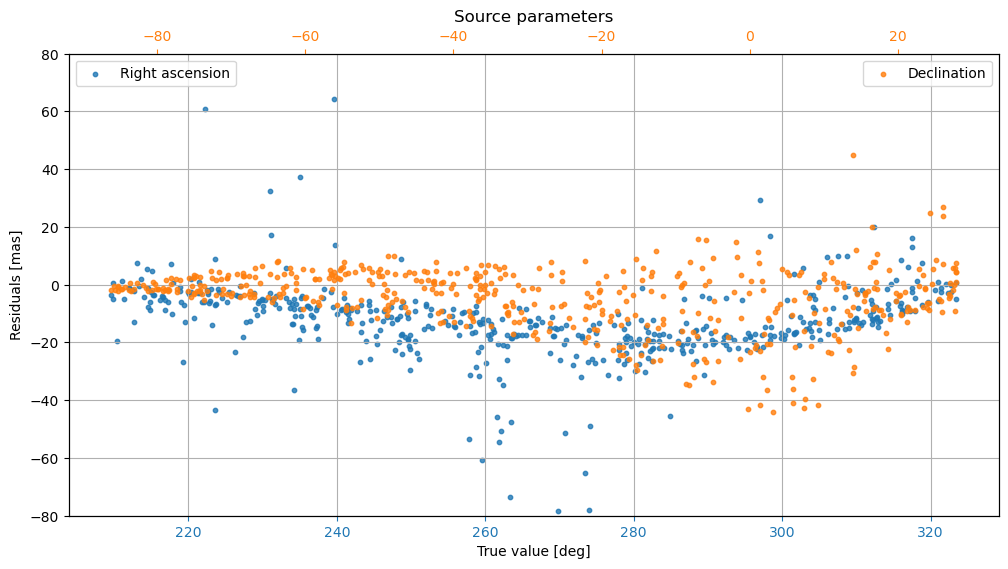

In [16]:
fig,ax = plt.subplots(figsize=(12,6))
ax.scatter(np.rad2deg(src[:,1]),(src_opt[:,1] - src[:,1])*_radiants_to_mas,label="Right ascension",s=10,alpha=0.8,color="tab:blue");

ax2 = ax.twiny()
ax2.scatter(np.rad2deg(src[:,2]),(src_opt[:,2] - src[:,2])*_radiants_to_mas,label="Declination",s=10,alpha=0.8,color="tab:orange");

ax.legend(loc="upper left")
ax2.legend(loc="upper right")
ax.tick_params(axis='x', colors='tab:blue')
ax2.tick_params(axis='x', colors='tab:orange')
ax.set_ylabel("Residuals [mas]")
ax.set_xlabel("True value [deg]")
ax.set_title("Source parameters")
ax.set_ylim(-80,80);
ax.grid();

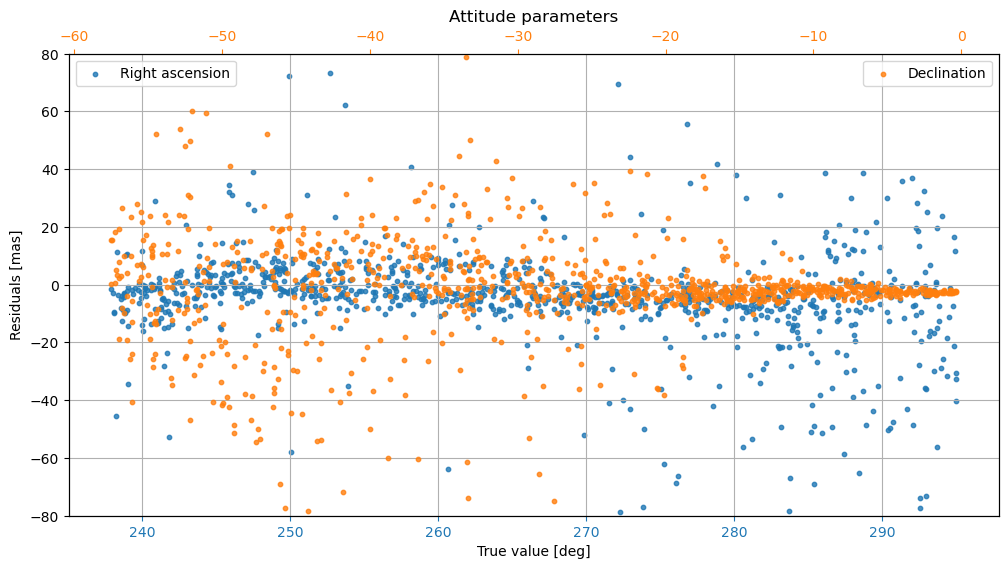

In [17]:
fig,ax = plt.subplots(figsize=(12,6))

ax.scatter(np.rad2deg(att[:,2]),(att_opt[:,2] - att[:,2])*_radiants_to_mas,label="Right ascension",s=10,alpha=0.8,color="tab:blue");

ax2 = ax.twiny()
ax2.scatter(np.rad2deg(att[:,3]),(att_opt[:,3] - att[:,3])*_radiants_to_mas,label="Declination",s=10,alpha=0.8,color="tab:orange");

ax.legend(loc="upper left")
ax2.legend(loc="upper right")
ax.tick_params(axis='x', colors='tab:blue')
ax2.tick_params(axis='x', colors='tab:orange')
ax.set_ylabel("Residuals [mas]")
ax.set_xlabel("True value [deg]")
ax.set_title("Attitude parameters")
ax.set_ylim(-80,80);
ax.grid();

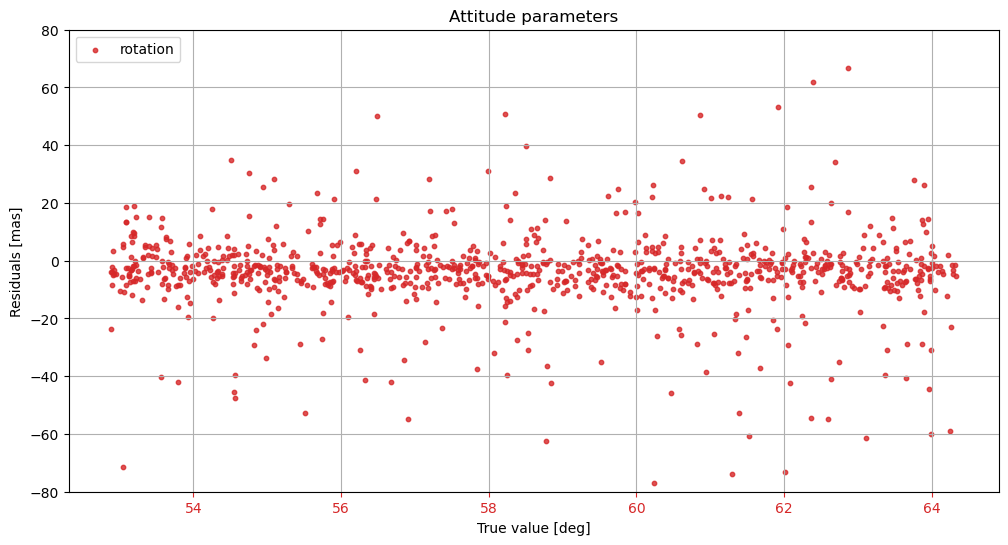

In [18]:
fig,ax = plt.subplots(figsize=(12,6))

ax.scatter(np.rad2deg(att[:,4]),(att_opt[:,4] - att[:,4])*_radiants_to_mas,label="rotation",s=10,alpha=0.8,color="tab:red");

ax.legend(loc="upper left")
ax.tick_params(axis='x', colors='tab:red')
ax.set_ylabel("Residuals [mas]")
ax.set_xlabel("True value [deg]")
ax.set_title("Attitude parameters")
ax.set_ylim(-80,80);
ax.grid();

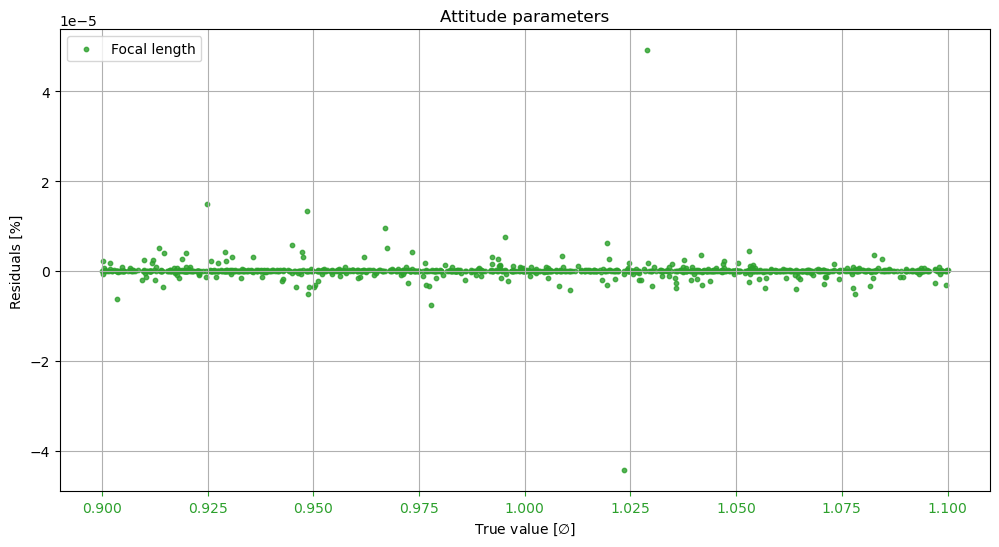

In [19]:
fig,ax = plt.subplots(figsize=(12,6))

ax.scatter(att[:,5],(att_opt[:,5] - att[:,5]),label="Focal length",s=10,alpha=0.8,color="tab:green");

ax.legend(loc="upper left")
ax.tick_params(axis='x', colors='tab:green')
ax.set_ylabel("Residuals [%]")
ax.set_xlabel(r"True value [$\emptyset$]")
ax.set_title("Attitude parameters")
#ax.set_ylim(-0.0005,0.0005);
ax.grid();

# Test 2: different FoVs

## Generate true values

In [6]:
# real values
pkey = jax.random.PRNGKey(42)

#simulate stars
sky_patch_size = 2
source_id = np.arange(5000)
alpha0 = np.deg2rad(np.random.uniform(-sky_patch_size/2, sky_patch_size/2, size=source_id.shape))
delta0 = np.deg2rad(np.random.uniform(-sky_patch_size/2, sky_patch_size/2, size=source_id.shape))

fovs = [
    [(-0.2,0),0,1,0.5,0,200],
    [(+0.2,0),0,1,0.5,0.1,200],
    [(0,-0.2),0,1,0.5,0.2,200],
    [(0,+0.2),0,1,0.5,0.3,200]
]

atts = []
FoV_sizes = []
last_exp_id = 0
for buffer in fovs:
    fov_loc,fov_rot,fov_F,fov_size,delta_t,num_exp = buffer
    exposure_id_ = last_exp_id + jnp.arange(num_exp)
    time_ = np.linspace(0,3, exposure_id_.size) + delta_t
    pt_ra_ = np.deg2rad(fov_loc[0] + np.random.uniform(-fov_size/5, fov_size/5, size=exposure_id_.shape))
    pt_dec_ = np.deg2rad(fov_loc[1] + np.random.uniform(-fov_size/5, fov_size/5, size=exposure_id_.shape))
    pt_rot_ = np.deg2rad(fov_rot + np.random.uniform(-1e-12, 1e-12, size=exposure_id_.shape))
    F_ = fov_F*np.random.uniform(0.9,1.1, size=exposure_id_.shape)
    att_ = np.stack([exposure_id_, time_, pt_ra_,pt_dec_,pt_rot_,F_]).T
    atts.append(att_)
    last_exp_id = exposure_id_[-1] + 1
    fs_ = np.deg2rad(fov_size)*np.ones(exposure_id_.size)
    FoV_sizes.append(fs_)

src = np.stack([source_id, alpha0, delta0]).T
att = np.vstack((atts))
FoV_sizes = np.hstack(FoV_sizes)

In [7]:
scipy.stats.describe(pt_rot_*_radiants_to_mas)

DescribeResult(nobs=200, minmax=(-3.5626265022413673e-06, 3.5623438236091823e-06), mean=-3.0799157230447e-07, variance=4.104182781096163e-12, skewness=0.35182593172830834, kurtosis=-0.9848129408010862)

In [8]:
src.shape

(5000, 3)

In [9]:
att.shape

(800, 6)

In [10]:
FoV_sizes.shape

(800,)

## Generate first guess

In [11]:
src_guess_error = 10/_radiants_to_mas #based on Gaia positional precision
att_guess_error = 1000/_radiants_to_mas

src_guess_errors = np.random.uniform(-src_guess_error, src_guess_error, size=src[:, 1:].shape)
shat = src + 0
shat[:,1:] = src[:,1:] + src_guess_errors

att_guess_errors = np.random.uniform(-att_guess_error, att_guess_error, size=att[:, 2:].shape)
ahat = att + 0
ahat[:,2:] = att[:,2:] + att_guess_errors

In [12]:
src[0]

array([0.        , 0.00524955, 0.00150465])

## Generate model

In [10]:
model = jax.jit(lambda s,a,c,t: jnp.asarray(_comrs2fprs(s[0],s[1],a[0],a[1],a[2],a[3])))

## Generate mock observations

In [11]:
sig_obs = 100/_radiants_to_mas
obs = generate_mock_obs(src,att,None,model,FoV_sizes,sig_obs)

In [12]:
obs.shape

(530242, 4)

In [13]:
df = pd.DataFrame(obs,columns=["sid","expid","axis","value"])

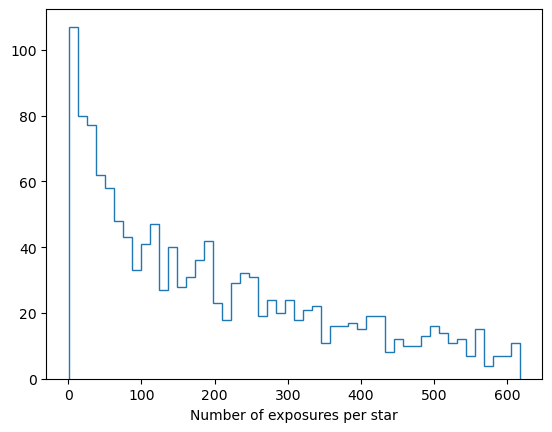

In [14]:
plt.hist(df.groupby(["sid","axis"]).count().query("axis==0")["value"],bins=50,histtype="step");
plt.xlabel("Number of exposures per star");

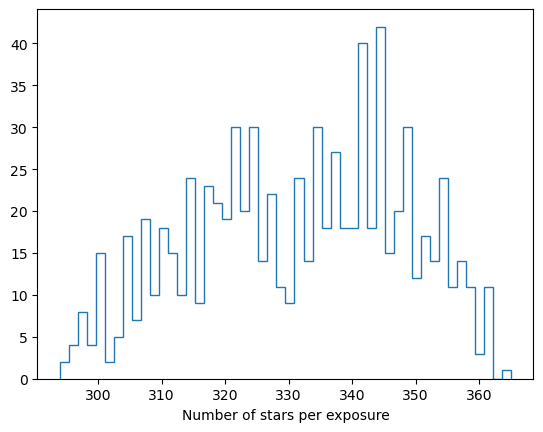

In [15]:
plt.hist(df.groupby(["expid","axis"]).count().query("axis==0")["value"],bins=50,histtype="step");
plt.xlabel("Number of stars per exposure");

In [16]:
observed_sid = np.vstack(df.groupby(["sid","axis"]).count().query("axis==0").query("value>10").index.values)[:,0]

In [17]:
src_obs_mask = np.isin(src[:,0],observed_sid)

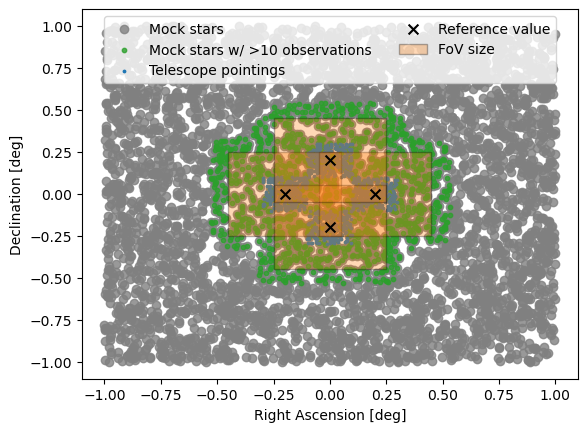

In [18]:
from matplotlib.patches import Rectangle

fig,ax = plt.subplots()

ax.scatter(np.rad2deg(src[:,1]),np.rad2deg(src[:,2]),color="grey",alpha=0.8,label="Mock stars")
ax.scatter(np.rad2deg(src[src_obs_mask,1]),np.rad2deg(src[src_obs_mask,2]),color="tab:green",
           alpha=0.8,s=10,label="Mock stars w/ >10 observations")

ax.scatter(np.rad2deg(att[:,2]),np.rad2deg(att[:,3]),zorder=1,s=3,label="Telescope pointings")
for i,aux in enumerate(fovs):
    if i == 0:
        ax.scatter(aux[0][0],aux[0][1],marker="x",color="k",s=50,zorder=100,label="Reference value")
        left, bottom, width, height = [aux[0][0]-aux[3]/2,aux[0][1]-aux[3]/2,aux[3],aux[3]]
        rect = plt.Rectangle((left, bottom), width, height,
                         facecolor="tab:orange",edgecolor="k", alpha=0.3,label="FoV size")
    else:
        ax.scatter(aux[0][0],aux[0][1],marker="x",color="k",s=50,zorder=100)
        left, bottom, width, height = [aux[0][0]-aux[3]/2,aux[0][1]-aux[3]/2,aux[3],aux[3]]
        rect = plt.Rectangle((left, bottom), width, height,
                         facecolor="tab:orange",edgecolor="k", alpha=0.3)
    ax.add_patch(rect)

ax.legend(ncols=2,loc="upper center")
ax.set_xlabel("Right Ascension [deg]")
ax.set_ylabel("Declination [deg]");

## Block iteration

In [19]:
%%time
src_opt,att_opt,cal_opt = bloc_iteration(shat,ahat,None,obs,model,2,5,2)

CPU times: user 17min 3s, sys: 1min 54s, total: 18min 58s
Wall time: 19min 48s


## Plots

In [59]:
original_att_df = pd.DataFrame(att,columns=["eid","time","alfa0","delta0","rot0","F0"]).sort_values(by="eid")

In [60]:
result_att_df = pd.DataFrame(att_opt,columns=["eid","time","alfa0_est","delta0_est","rot0_est","F0_est"]).sort_values(by="eid")

In [61]:
guess_att_df = pd.DataFrame(ahat,columns=["eid","time","alfa0_guess","delta0_guess","rot0_guess","F0_guess"]).sort_values(by="eid")

In [62]:
original_df = pd.DataFrame(src,columns=["sid","alfa0","delta0"]).sort_values(by="sid")

In [63]:
result_df = pd.DataFrame(src_opt,columns=["sid","alfa0_est","delta0_est"]).sort_values(by="sid")

In [64]:
guess_df = pd.DataFrame(shat,columns=["sid","alfa0_guess","delta0_guess"]).sort_values(by="sid")

In [65]:
obs_df = pd.DataFrame(obs,columns=["sid","eid","axis","value"])

In [66]:
num_exp = (obs_df.groupby("sid").count()["value"].values/2).astype(int)

In [67]:
num_sources = (obs_df.groupby("eid").count()["value"].values/2).astype(int)

In [68]:
num_exp_df = obs_df.groupby("sid").count()["value"]

In [72]:
result_df = result_df.join(original_df,rsuffix="_o")[["sid","alfa0","delta0","alfa0_est","delta0_est"]]
result_df = result_df.join(guess_df,rsuffix="_o")[["sid","alfa0","delta0","alfa0_est","delta0_est","alfa0_guess","delta0_guess"]]

In [73]:
for index in num_exp_df.index:
    numexp = num_exp_df.loc[index]
    result_df.loc[index,"num_exp"] = int(numexp/2)

In [74]:
result_df

,sid,alfa0,delta0,alfa0_est,delta0_est,alfa0_guess,delta0_guess,num_exp
0,0.0,0.004170,0.005577,0.004170,0.005577,0.004170,0.005577,129.0
1,1.0,-0.008561,-0.016672,-0.008561,-0.016672,-0.008561,-0.016672,NaN
2,2.0,-0.009717,0.013868,-0.009717,0.013868,-0.009717,0.013868,NaN
3,3.0,-0.007094,-0.010280,-0.007094,-0.010280,-0.007094,-0.010280,NaN
4,4.0,0.010851,0.015804,0.010851,0.015804,0.010851,0.015804,NaN
...,...,...,...,...,...,...,...,...
4995,4995.0,0.004505,-0.016948,0.004505,-0.016948,0.004505,-0.016948,NaN
4996,4996.0,-0.011388,-0.007270,-0.011388,-0.007270,-0.011388,-0.007270,NaN
4997,4997.0,0.008976,-0.005458,0.008976,-0.005458,0.008976,-0.005458,4.0
4998,4998.0,-0.007999,-0.008112,-0.007999,-0.008112,-0.007999,-0.008112,NaN


In [83]:
result_att_df = result_att_df.join(original_att_df,rsuffix="_o")[["eid","alfa0","delta0","rot0","F0",
                                                                  "alfa0_est","delta0_est","rot0_est","F0_est"]]

result_att_df = result_att_df.join(guess_att_df,rsuffix="_o")[["eid","alfa0","delta0","rot0","F0",
                                                                  "alfa0_est","delta0_est","rot0_est","F0_est",
                                                              "alfa0_guess","delta0_guess","rot0_guess","F0_guess"]]

In [84]:
result_att_df["num_src"] = num_sources

In [85]:
result_att_df

,eid,alfa0,delta0,rot0,F0,alfa0_est,delta0_est,rot0_est,F0_est,alfa0_guess,delta0_guess,rot0_guess,F0_guess,num_src
0,0.0,-0.002036,0.001288,4.099161e-15,1.049147,-0.002036,0.001288,-0.000006,1.049152,-0.002038,0.001284,1.033315e-06,1.049148,335
1,1.0,-0.002380,-0.000381,9.664515e-16,1.052309,-0.002380,-0.000381,0.000008,1.052312,-0.002385,-0.000383,-1.451841e-06,1.052312,317
2,2.0,-0.002760,-0.000426,-9.180808e-15,0.971681,-0.002760,-0.000426,0.000009,0.971699,-0.002757,-0.000427,-4.459541e-06,0.971685,310
3,3.0,-0.001834,0.001573,2.664797e-15,0.971556,-0.001834,0.001573,0.000004,0.971560,-0.001832,0.001569,2.178694e-06,0.971555,333
4,4.0,-0.004641,0.000728,-7.342246e-15,1.004426,-0.004641,0.000728,-0.000003,1.004433,-0.004638,0.000726,-2.900205e-06,1.004428,332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,795.0,0.001457,0.001883,1.616324e-15,1.060153,0.001457,0.001883,-0.000004,1.060149,0.001459,0.001882,5.260333e-07,1.060152,347
796,796.0,0.001511,0.002181,-1.625698e-14,1.085937,0.001511,0.002181,-0.000012,1.085933,0.001507,0.002177,2.629218e-06,1.085936,349
797,797.0,-0.000732,0.005205,1.712590e-14,1.074327,-0.000732,0.005205,0.000003,1.074342,-0.000733,0.005207,-1.266749e-06,1.074323,312
798,798.0,0.001597,0.002149,1.701566e-14,1.093581,0.001597,0.002149,-0.000009,1.093574,0.001595,0.002145,1.968243e-06,1.093577,350


In [86]:
result_df.to_csv("/Users/pauramos/Downloads/results_test_4FoV_800exposures_with10mas1stGuess_sourceparams.csv",index=False)

In [87]:
result_att_df.to_csv("/Users/pauramos/Downloads/results_test_4FoV_800exposures_with10mas1stGuess_attitudeparams.csv",index=False)

In [102]:
xbins = np.arange(0,650,20)
mean_error_alfa,_,_ = scipy.stats.binned_statistic(result_df["num_exp"],
                                                   (result_df["alfa0_est"] - result_df["alfa0"])*_radiants_to_mas,
                                                   statistic="mean",
                                                   bins=xbins)

mean_error_delta,_,_ = scipy.stats.binned_statistic(result_df["num_exp"],
                                                   (result_df["delta0_est"] - result_df["delta0"])*_radiants_to_mas,
                                                   statistic="mean",
                                                   bins=xbins)

std_error_alfa,_,_ = scipy.stats.binned_statistic(result_df["num_exp"],
                                                   (result_df["alfa0_est"] - result_df["alfa0"])*_radiants_to_mas,
                                                   statistic="std",
                                                   bins=xbins)

std_error_delta,_,_ = scipy.stats.binned_statistic(result_df["num_exp"],
                                                   (result_df["delta0_est"] - result_df["delta0"])*_radiants_to_mas,
                                                   statistic="std",
                                                   bins=xbins)

/var/folders/vj/7jqz0m1j2zs3t7fxnl0d1gfw0000gn/T/ipykernel_65628/756513080.py:15: RuntimeWarning: divide by zero encountered in divide
  plt.plot(xbins[:-1],sig_obs*_radiants_to_mas/np.sqrt(xbins[:-1]),color="k",ls="-.",label=r"$\sigma_{obs}/\sqrt{nobs}$")
/var/folders/vj/7jqz0m1j2zs3t7fxnl0d1gfw0000gn/T/ipykernel_65628/756513080.py:16: RuntimeWarning: divide by zero encountered in divide
  plt.plot(xbins[:-1],-sig_obs*_radiants_to_mas/np.sqrt(xbins[:-1]),color="k",ls="-.")


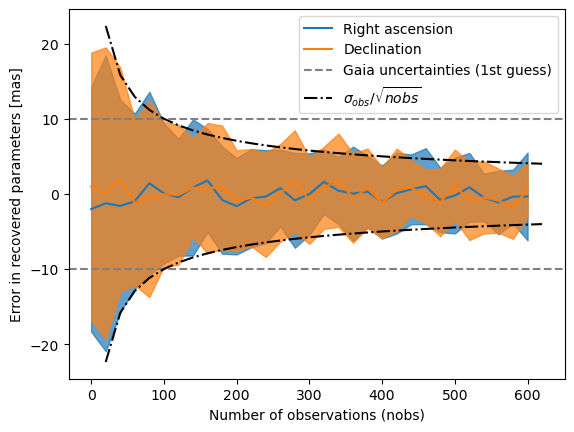

In [103]:
#plt.scatter(result_df["num_exp"],(result_df["alfa0_est"] - result_df["alfa0"])*_radiants_to_mas,s=1,alpha=0.5)
#plt.scatter(result_df["num_exp"],(result_df["delta0_est"] - result_df["delta0"])*_radiants_to_mas,s=1,alpha=0.5)

plt.plot(xbins[:-1],mean_error_alfa,label="Right ascension")
plt.plot(xbins[:-1],mean_error_delta,label="Declination")

plt.fill_between(xbins[:-1],mean_error_alfa-1*std_error_alfa,mean_error_alfa+1*std_error_alfa,alpha=0.7,color="tab:blue")
plt.fill_between(xbins[:-1],mean_error_delta-1*std_error_delta,mean_error_delta+1*std_error_delta,alpha=0.7,color="tab:orange")

plt.axhline(src_guess_error*_radiants_to_mas,ls="--",color="grey",label="Gaia uncertainties (1st guess)")
plt.axhline(-src_guess_error*_radiants_to_mas,ls="--",color="grey")
#plt.axhline(sig_obs*_radiants_to_mas,ls=":",color="grey",label=r"Observational uncertainties ($\sigma_{obs}$)")
#plt.axhline(-sig_obs*_radiants_to_mas,ls=":",color="grey")

plt.plot(xbins[:-1],sig_obs*_radiants_to_mas/np.sqrt(xbins[:-1]),color="k",ls="-.",label=r"$\sigma_{obs}/\sqrt{nobs}$")
plt.plot(xbins[:-1],-sig_obs*_radiants_to_mas/np.sqrt(xbins[:-1]),color="k",ls="-.")
         
plt.legend()

plt.xlabel("Number of observations (nobs)")
plt.ylabel("Error in recovered parameters [mas]");

In [110]:
xbins = np.arange(200,400,5)
mean_error_alfa_att,_,_ = scipy.stats.binned_statistic(result_att_df["num_src"],
                                                   (result_att_df["alfa0_est"] - result_att_df["alfa0"])*_radiants_to_mas,
                                                   statistic="mean",
                                                   bins=xbins)

mean_error_delta_att,_,_ = scipy.stats.binned_statistic(result_att_df["num_src"],
                                                   (result_att_df["delta0_est"] - result_att_df["delta0"])*_radiants_to_mas,
                                                   statistic="mean",
                                                   bins=xbins)

mean_error_rot_att,_,_ = scipy.stats.binned_statistic(result_att_df["num_src"],
                                                   (result_att_df["rot0_est"] - result_att_df["rot0"])*_radiants_to_mas,
                                                   statistic="mean",
                                                   bins=xbins)

std_error_alfa_att,_,_ = scipy.stats.binned_statistic(result_att_df["num_src"],
                                                   (result_att_df["alfa0_est"] - result_att_df["alfa0"])*_radiants_to_mas,
                                                   statistic="std",
                                                   bins=xbins)

std_error_delta_att,_,_ = scipy.stats.binned_statistic(result_att_df["num_src"],
                                                   (result_att_df["delta0_est"] - result_att_df["delta0"])*_radiants_to_mas,
                                                   statistic="std",
                                                   bins=xbins)

std_error_rot_att,_,_ = scipy.stats.binned_statistic(result_att_df["num_src"],
                                                   (result_att_df["rot0_est"] - result_att_df["rot0"])*_radiants_to_mas,
                                                   statistic="std",
                                                   bins=xbins)

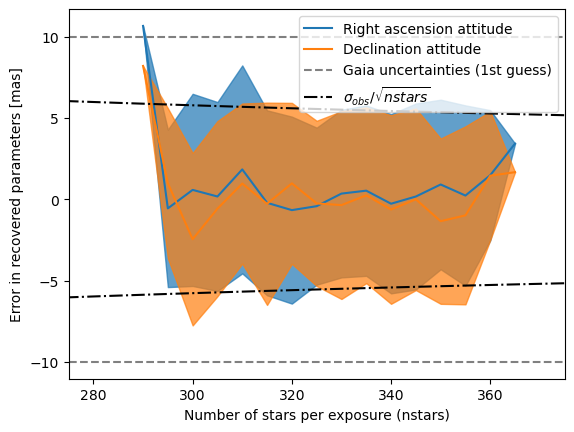

In [113]:
#plt.scatter(result_df["num_exp"],(result_df["alfa0_est"] - result_df["alfa0"])*_radiants_to_mas,s=1,alpha=0.5)
#plt.scatter(result_df["num_exp"],(result_df["delta0_est"] - result_df["delta0"])*_radiants_to_mas,s=1,alpha=0.5)

plt.plot(xbins[:-1],mean_error_alfa_att,label="Right ascension attitude")
plt.plot(xbins[:-1],mean_error_delta_att,label="Declination attitude")
#plt.plot(xbins[:-1],mean_error_rot_att,label="Rotation attitude",color="tab:red")

plt.fill_between(xbins[:-1],mean_error_alfa_att-1*std_error_alfa_att,
                 mean_error_alfa_att+1*std_error_alfa_att,alpha=0.7,color="tab:blue")
plt.fill_between(xbins[:-1],mean_error_delta_att-1*std_error_delta_att,
                 mean_error_delta_att+1*std_error_delta_att,alpha=0.7,color="tab:orange")
#plt.fill_between(xbins[:-1],mean_error_rot_att-1*std_error_rot_att,
#                 mean_error_rot_att+1*std_error_rot_att,alpha=0.7,color="tab:red")

plt.axhline(src_guess_error*_radiants_to_mas,ls="--",color="grey",label="Gaia uncertainties (1st guess)")
plt.axhline(-src_guess_error*_radiants_to_mas,ls="--",color="grey")
#plt.axhline(sig_obs*_radiants_to_mas,ls=":",color="grey",label="Observational uncertainties")
#plt.axhline(-sig_obs*_radiants_to_mas,ls=":",color="grey")

plt.plot(xbins[:-1],sig_obs*_radiants_to_mas/np.sqrt(xbins[:-1]),color="k",ls="-.",label=r"$\sigma_{obs}/\sqrt{nstars}$")
plt.plot(xbins[:-1],-sig_obs*_radiants_to_mas/np.sqrt(xbins[:-1]),color="k",ls="-.")

plt.legend()

plt.xlim(275,375)

plt.xlabel("Number of stars per exposure (nstars)")
plt.ylabel("Error in recovered parameters [mas]");

In [114]:
scipy.stats.describe((result_att_df.rot0-result_att_df.rot0_est).values*_radiants_to_mas)

DescribeResult(nobs=800, minmax=(-4523.232295982288, 4641.252295210815), mean=128.3615583590015, variance=2449395.1536554894, skewness=-0.0046727185335996855, kurtosis=-0.03161907053464397)

In [115]:
scipy.stats.describe((result_att_df.F0-result_att_df.F0_est).values)

DescribeResult(nobs=800, minmax=(-2.2293160542030677e-05, 2.2863412333040678e-05), mean=2.3233167133887566e-07, variance=5.51163753126859e-11, skewness=0.0047131177722012545, kurtosis=-0.07571615456072056)

# Test 3: aberration

In [5]:
_icrs2comrs(np.deg2rad(266),np.deg2rad(-28),0,np.array([1,0,0,30000,0,0]))

(Array(-1.64049641, dtype=float64), Array(-0.48869547, dtype=float64))

# Measuring computing times

In [20]:
%%timeit
_iterate_src = jax.vmap(model, (0, None, None, None), 0)
    #prepare the Jacobian matrix wrt attitude parameters
        #the jacobian has to be iterated over all sources (To-Do: and calibration units)
_Jda = _Jacobian_autodiff(model,1,(0,None,None,None))

14.6 μs ± 103 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [21]:
%%timeit
update_attitude_inner(src,att[0],None,obs,model)

6.29 ms ± 527 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [118]:
from decimal import Decimal

'%.2E' % Decimal(str(5e4*1.5e6))

'7.50E+10'